In [4]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import LinearSVC
import pandas as pd

# Load the dataset
df = pd.read_csv('winequality-red.csv', header = 0, delimiter=';')

# Preparing the data in in terms of inputs and outputs
X = df.drop('quality', axis=1)
y = df['quality']

# Splitting the data with stratification turned on
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# Define a pipeline setup for the SVC model with linear kernal and l1 regularization
pipe1 = Pipeline([
    ('scaling', 'passthrough'),
    ('feature_selection', SelectFromModel(LinearSVC(max_iter=5000, dual=False, penalty='l1', random_state=42))),
    ('classification', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Define a pipeline setup for the RFE using the random forest classifier
pipe2 = Pipeline([
    ('scaling', 'passthrough'),
    ('feature_selection', RFE(estimator=RandomForestClassifier(random_state=42))),
    ('classification', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Define the grid search containing the two pipelines above
param_grid = [
    {
        'pipeline': [pipe1],
        'pipeline__scaling': [MinMaxScaler(), StandardScaler()],
        'pipeline__feature_selection__estimator__C': [0.01, 0.1, 1, 10],
        'pipeline__classification__n_estimators': [100, 200, 300],
        'pipeline__classification__max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
        'pipeline__classification__min_samples_split': [1, 2, 5, 10],
        'pipeline__classification__min_samples_leaf': [1, 2, 4],
        'pipeline__classification__bootstrap': [True, False]
    },
    {
        'pipeline': [pipe2],
        'pipeline__scaling': [MinMaxScaler(), StandardScaler()],
        'pipeline__feature_selection__n_features_to_select': [5,7,9,11],
        'pipeline__classification__n_estimators': [100, 200, 300],
        'pipeline__classification__max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
        'pipeline__classification__min_samples_split': [1, 2, 5, 10],
        'pipeline__classification__min_samples_leaf': [1, 2, 4],
        'pipeline__classification__bootstrap': [True, False]
    },
]

# Perform the grid search
grid_search = GridSearchCV(Pipeline([('pipeline', None)]), param_grid=param_grid, scoring='f1_weighted', cv=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Making predictions based on the gridsearch above
y_pred = grid_search.predict(X_test)




c:\Users\amera\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
31680 fits failed out of a total of 126720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15840 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\amera\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\amera\anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\amera\anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step

Best parameters: {'pipeline': Pipeline(steps=[('scaling', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=LinearSVC(C=0.01, dual=False,
                                                     max_iter=5000,
                                                     penalty='l1',
                                                     random_state=42))),
                ('classification',
                 RandomForestClassifier(class_weight='balanced', max_depth=20,
                                        n_estimators=300, random_state=42))]), 'pipeline__classification__bootstrap': True, 'pipeline__classification__max_depth': 20, 'pipeline__classification__min_samples_leaf': 1, 'pipeline__classification__min_samples_split': 2, 'pipeline__classification__n_estimators': 300, 'pipeline__feature_selection__estimator__C': 0.01, 'pipeline__scaling': StandardScaler()}


In [5]:
from sklearn.metrics import classification_report

# Printing the classification report
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.74      0.72      0.73       141
           6       0.72      0.63      0.67       146
           7       0.55      0.69      0.61        32
           8       0.33      1.00      0.50         1

    accuracy                           0.68       320
   macro avg       0.39      0.51      0.42       320
weighted avg       0.71      0.68      0.69       320



c:\Users\amera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\amera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\amera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
# Best results had a 69% weighted average. More finetuning around the tested parameters will be performed. Previous cell took 115 mins, 25 seconds to run.

# Using only the linearSVC pipeline from above based on gridsearchCV results
pipe = Pipeline([
    ('scaling', 'passthrough'),
    ('feature_selection', SelectFromModel(LinearSVC(max_iter=5000, dual=False, penalty='l1', random_state=42))),
    ('classification', RandomForestClassifier(class_weight='balanced', random_state=42))
])


# Finetuning the RFC parameters, and using only standardscaler for scaling the data
param_grid = [
    {
        'scaling': [StandardScaler()],
        'feature_selection__estimator__C': [0.01, 0.1, 1, 10],
        'classification__n_estimators': [290, 295, 300, 305, 310],
        'classification__max_depth': [None, 10, 15, 17, 18, 19, 20, 21, 22],
        'classification__min_samples_split': [1, 2, 3, 4],
        'classification__min_samples_leaf': [1, 2, 3],
        'classification__bootstrap': [True]
    },
]

# Performing the grid search
grid_search = GridSearchCV(pipe, param_grid=param_grid, scoring='f1_weighted', cv=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Printing the best parameters from the gridsearch above
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Making predictions based on the gridsearch above
y_pred = grid_search.predict(X_test)

# Printing the classification report
print(classification_report(y_pred,y_test))


c:\Users\amera\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\amera\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5400 fits failed out of a total of 21600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5400 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\amera\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\amera\anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_es

Best parameters: {'classification__bootstrap': True, 'classification__max_depth': 19, 'classification__min_samples_leaf': 1, 'classification__min_samples_split': 3, 'classification__n_estimators': 295, 'feature_selection__estimator__C': 0.01, 'scaling': StandardScaler()}
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.74      0.74      0.74       136
           6       0.71      0.61      0.66       149
           7       0.57      0.68      0.62        34
           8       0.33      1.00      0.50         1

    accuracy                           0.67       320
   macro avg       0.39      0.50      0.42       320
weighted avg       0.71      0.67      0.69       320



c:\Users\amera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\amera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\amera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
# Weighted average hasn't gone up, and accuracy has gone down. So has the weighted avg recall. Previous code ran for 13 mins 40 seconds

# Using same pipeline from above
pipe = Pipeline([
    ('scaling', 'passthrough'),
    ('feature_selection', SelectFromModel(LinearSVC(max_iter=5000, dual=False, penalty='l1', random_state=42))),
    ('classification', RandomForestClassifier(class_weight='balanced', random_state=42))
])


# Finetuning the RFC parameters
param_grid = [
    {
        'scaling': [StandardScaler()],
        'feature_selection__estimator__C': [0.01, 0.02, 0.03, 0.04],
        'classification__n_estimators': [290, 291, 292, 293, 294, 295, 296],
        'classification__max_depth': [None, 10, 15, 17, 18, 19, 20],
        'classification__min_samples_split': [1, 2, 3, 4],
        'classification__min_samples_leaf': [1, 2],
        'classification__bootstrap': [True]
    },
]

# Performing the grid search
grid_search = GridSearchCV(pipe, param_grid=param_grid, scoring='f1_weighted', cv=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Printing the best parameters from the gridsearch above
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Making predictions based on the gridsearch above
y_pred = grid_search.predict(X_test)

# Printing the classification report
print(classification_report(y_pred,y_test))

c:\Users\amera\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\amera\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
3920 fits failed out of a total of 15680.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3920 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\amera\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\amera\anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_es

Best parameters: {'classification__bootstrap': True, 'classification__max_depth': 17, 'classification__min_samples_leaf': 1, 'classification__min_samples_split': 4, 'classification__n_estimators': 292, 'feature_selection__estimator__C': 0.02, 'scaling': StandardScaler()}
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       0.75      0.73      0.74       139
           6       0.73      0.63      0.68       147
           7       0.57      0.74      0.65        31
           8       0.33      0.50      0.40         2

    accuracy                           0.68       320
   macro avg       0.40      0.43      0.41       320
weighted avg       0.72      0.68      0.70       320



c:\Users\amera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\amera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\amera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
# Weighted average has improved allong side with accuracy. Precision slightly went up. Slightly tuning parameters more. Previous code ran for 9 minutes 24.3 seconds. Trying out balanced and balanced subsample next

# Defining the pipeline 
pipe = Pipeline([
    ('scaling', 'passthrough'),
    ('feature_selection', SelectFromModel(LinearSVC(max_iter=5000, dual=False, penalty='l1', random_state=42))),
    ('classification', RandomForestClassifier(random_state=42))
])


# Finetuning the RFC parameters
param_grid = [
    {
        'scaling': [StandardScaler()],
        'feature_selection__estimator__C': [0.18, 0.19, 0.02, 0.021, 0.022],
        'classification__n_estimators': [290, 291, 292, 293, 294, 295, 296],
        'classification__max_depth': [None, 15, 16, 17, 18, 19, 20],
        'classification__min_samples_split': [3, 4, 5],
        'classification__min_samples_leaf': [1, 2],
        'classification__class_weight': ['balanced','balanced subsample'],
        'classification__bootstrap': [True]
    },
]

# Performing the grid search
grid_search = GridSearchCV(pipe, param_grid=param_grid, scoring='f1_weighted', cv=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Printing the best parameters from the gridsearch above
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Making predictions based on the gridsearch above
y_pred = grid_search.predict(X_test)

# Printing the classification report
print(classification_report(y_pred,y_test))

c:\Users\amera\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\amera\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
14700 fits failed out of a total of 29400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
14700 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\amera\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\amera\anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_

Best parameters: {'classification__bootstrap': True, 'classification__class_weight': 'balanced', 'classification__max_depth': 17, 'classification__min_samples_leaf': 1, 'classification__min_samples_split': 4, 'classification__n_estimators': 292, 'feature_selection__estimator__C': 0.02, 'scaling': StandardScaler()}
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       0.75      0.73      0.74       139
           6       0.73      0.63      0.68       147
           7       0.57      0.74      0.65        31
           8       0.33      0.50      0.40         2

    accuracy                           0.68       320
   macro avg       0.40      0.43      0.41       320
weighted avg       0.72      0.68      0.70       320



c:\Users\amera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\amera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\amera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1]:
# Interestingly enough, when I put C = 0.2 by accident
# instead of 0.02, it improved the accuracy.
# Will retest the C term, as well as balanced class weights for the feature_selection

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import LinearSVC
import pandas as pd
from sklearn.metrics import classification_report

# Load the dataset
df = pd.read_csv('winequality-red.csv', header = 0, delimiter=';')

# Prepare the data
X = df.drop('quality', axis=1)
y = df['quality']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y)

# Defining the pipeline 
pipe = Pipeline([
    ('scaling', StandardScaler()),
    ('feature_selection', SelectFromModel(LinearSVC(max_iter=100000,
                                                     dual=False,
                                                     penalty='l1', 
                                                     random_state=42,
                                                     C=0.2))),
    ('classification', RandomForestClassifier(random_state=42,
                                              bootstrap=True,
                                              class_weight='balanced',
                                              max_depth=17,min_samples_leaf=1,
                                              min_samples_split=4,
                                              n_estimators=292))
]).fit(X_train,y_train)

# Making predictions using the fitted RFC model
y_pred = pipe.predict(X_test)

# Printing the classification report
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       0.76      0.74      0.75       140
           6       0.74      0.64      0.69       149
           7       0.53      0.75      0.62        28
           8       0.33      0.50      0.40         2

    accuracy                           0.69       320
   macro avg       0.39      0.44      0.41       320
weighted avg       0.73      0.69      0.71       320



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
# Defining the pipeline 
pipe = Pipeline([
    ('scaling', 'passthrough'),
    ('feature_selection', SelectFromModel(LinearSVC(max_iter=5000, dual=False, penalty='l1', random_state=42))),
    ('classification', RandomForestClassifier(random_state=42))
])


# Finetuning the RFC parameters, checking if setting class weights to balanced on the linearSVC model improves accuracy
param_grid = [
    {
        'scaling': [StandardScaler()],
        'feature_selection__estimator__C': [0.02,0.2,0.3],
        'feature_selection__estimator__class_weight': ['balanced',None],
        'classification__n_estimators': [290, 291, 292, 293, 294, 295, 296],
        'classification__max_depth': [None, 15, 16, 17, 18, 19, 20],
        'classification__min_samples_split': [3, 4, 5],
        'classification__min_samples_leaf': [1, 2],
        'classification__class_weight': ['balanced'],
        'classification__bootstrap': [True]
    },
]

# Performing the grid search
grid_search = GridSearchCV(pipe, param_grid=param_grid, scoring='f1_weighted', cv=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Printing the best parameters from the gridsearch above
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Making predictions based on the gridsearch above
y_pred = grid_search.predict(X_test)

# Printing the classification report
print(classification_report(y_pred,y_test))

c:\Users\amera\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


Best parameters: {'classification__bootstrap': True, 'classification__class_weight': 'balanced', 'classification__max_depth': 17, 'classification__min_samples_leaf': 1, 'classification__min_samples_split': 4, 'classification__n_estimators': 292, 'feature_selection__estimator__C': 0.02, 'feature_selection__estimator__class_weight': None, 'scaling': StandardScaler()}
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       0.75      0.73      0.74       139
           6       0.73      0.63      0.68       147
           7       0.57      0.74      0.65        31
           8       0.33      0.50      0.40         2

    accuracy                           0.68       320
   macro avg       0.40      0.43      0.41       320
weighted avg       0.72      0.68      0.70       320



c:\Users\amera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\amera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\amera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
# Just fine tuning C now. No improvements from setting the class_weight parameter to balanced for linearSVC

# Defining the pipeline 
pipe = Pipeline([
    ('scaling', 'passthrough'),
    ('feature_selection', SelectFromModel(LinearSVC(max_iter=5000, dual=False, penalty='l1', random_state=42))),
    ('classification', RandomForestClassifier(random_state=42))
])


# Finetuning C for the feature selector 
param_grid = [
    {
        'scaling': [StandardScaler()],
        'feature_selection__estimator__C': [0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2],
        'feature_selection__estimator__class_weight': [None],
        'classification__n_estimators': [292],
        'classification__max_depth': [17],
        'classification__min_samples_split': [4],
        'classification__min_samples_leaf': [1],
        'classification__class_weight': ['balanced'],
        'classification__bootstrap': [True]
    },
]

# Performing the grid search
grid_search = GridSearchCV(pipe, param_grid=param_grid, scoring='f1_weighted', cv=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Printing the best parameters from the gridsearch above
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Making predictions based on the gridsearch above
y_pred = grid_search.predict(X_test)

# Printing the classification report
print(classification_report(y_pred,y_test))

c:\Users\amera\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


Best parameters: {'classification__bootstrap': True, 'classification__class_weight': 'balanced', 'classification__max_depth': 17, 'classification__min_samples_leaf': 1, 'classification__min_samples_split': 4, 'classification__n_estimators': 292, 'feature_selection__estimator__C': 0.1, 'feature_selection__estimator__class_weight': None, 'scaling': StandardScaler()}
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       0.76      0.74      0.75       140
           6       0.74      0.64      0.69       149
           7       0.53      0.75      0.62        28
           8       0.33      0.50      0.40         2

    accuracy                           0.69       320
   macro avg       0.39      0.44      0.41       320
weighted avg       0.73      0.69      0.71       320



c:\Users\amera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\amera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\amera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [111]:
# Just fine tuning C now in linearSVC.

# Defining the pipeline 
pipe = Pipeline([
    ('scaling', 'passthrough'),
    ('feature_selection', SelectFromModel(LinearSVC(max_iter=5000, dual=False, penalty='l1', random_state=42))),
    ('classification', RandomForestClassifier(random_state=42))
])


# Finetuning C for the feature selector at a lower range
param_grid = [
    {
        'scaling': [StandardScaler()],
        'feature_selection__estimator__C': [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1],
        'feature_selection__estimator__class_weight': [None],
        'classification__n_estimators': [292],
        'classification__max_depth': [17],
        'classification__min_samples_split': [4],
        'classification__min_samples_leaf': [1],
        'classification__class_weight': ['balanced'],
        'classification__bootstrap': [True]
    },
]

# Performing the grid search
grid_search = GridSearchCV(pipe, param_grid=param_grid, scoring='f1_weighted', cv=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Printing the best parameters from the gridsearch above
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Making predictions based on the gridsearch above
y_pred = grid_search.predict(X_test)

# Printing the classification report
print(classification_report(y_pred,y_test))

c:\Users\amera\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


Best parameters: {'classification__bootstrap': True, 'classification__class_weight': 'balanced', 'classification__max_depth': 17, 'classification__min_samples_leaf': 1, 'classification__min_samples_split': 4, 'classification__n_estimators': 292, 'feature_selection__estimator__C': 0.02, 'feature_selection__estimator__class_weight': None, 'scaling': StandardScaler()}
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       0.76      0.73      0.74       142
           6       0.72      0.64      0.68       143
           7       0.60      0.75      0.67        32
           8       0.33      0.50      0.40         2

    accuracy                           0.69       320
   macro avg       0.40      0.44      0.41       320
weighted avg       0.72      0.69      0.70       320



c:\Users\amera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\amera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\amera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [4]:
# Final model Results

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Load the dataset
df = pd.read_csv('winequality-red.csv', header = 0, delimiter=';')

# Prepare the data
X = df.drop(['quality'], axis=1)
y = df['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# Defining the pipeline 
pipe = Pipeline([
    ('scaling', StandardScaler()),
    ('feature_selection', SelectFromModel(LinearSVC(max_iter=100000, dual=False, penalty='l1', random_state=42, C=0.1))),
    ('classification', RandomForestClassifier(random_state=42,bootstrap=True,class_weight='balanced',max_depth=17,min_samples_leaf=1,min_samples_split=4,n_estimators=292))
]).fit(X_train,y_train)

# Make prediction base on X_test
y_pred = pipe.predict(X_test)

# Print the classification report
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       0.76      0.74      0.75       140
           6       0.74      0.64      0.69       149
           7       0.53      0.75      0.62        28
           8       0.33      0.50      0.40         2

    accuracy                           0.69       320
   macro avg       0.39      0.44      0.41       320
weighted avg       0.73      0.69      0.71       320



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [5]:
# Obtaining classification report on fitted model showcasing RFC overfitting
y_pred = pipe.predict(X_train)

# Print the classification report
print(classification_report(y_pred,y_train))



              precision    recall  f1-score   support

           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00        42
           5       1.00      1.00      1.00       545
           6       1.00      1.00      1.00       510
           7       1.00      1.00      1.00       159
           8       1.00      1.00      1.00        15

    accuracy                           1.00      1279
   macro avg       1.00      1.00      1.00      1279
weighted avg       1.00      1.00      1.00      1279



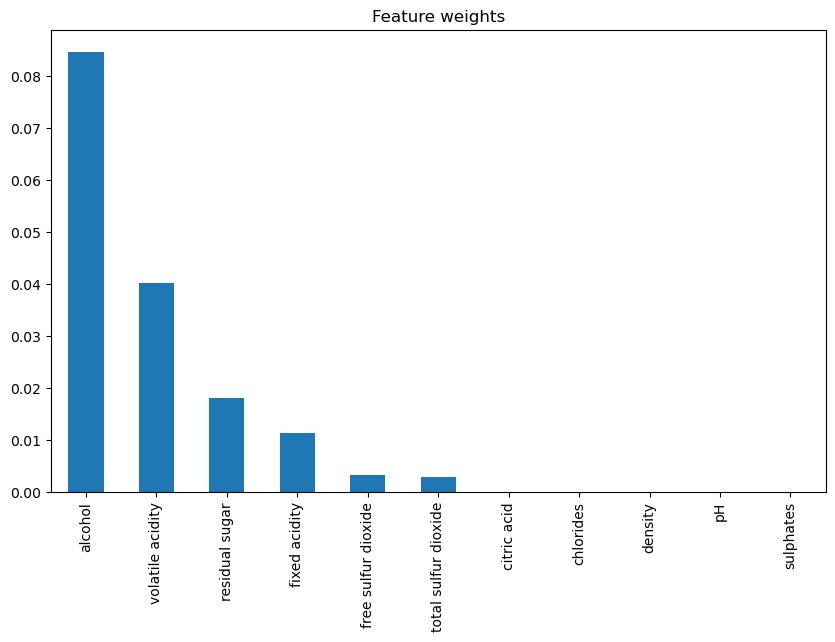

In [3]:
# Fit LinearSVC model separately
feature_selector = LinearSVC(max_iter=100000, dual=False, penalty='l1', random_state=42, C=0.1)
feature_selector.fit(X_train, y_train)

# Get the absolute values of the coefficients
weights = np.abs(feature_selector.coef_)[0]

# Create a Series to map weights to their corresponding feature names
weights_list = pd.Series(weights, index=X_train.columns)

# Sort the series for plotting
weights_list = weights_list.sort_values(ascending=False)

# Plot the weights
plt.figure(figsize=(10, 6))
weights_list.plot(kind='bar')
plt.title('Feature weights')
plt.show()



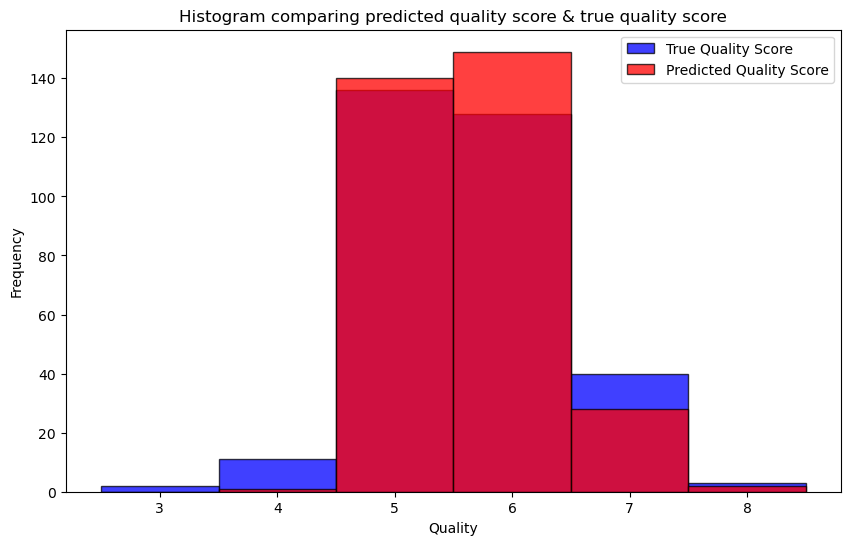

In [98]:
# Plot histogram
plt.figure(figsize=(10,6))

plt.hist(y_test, bins=np.arange(y.min(), y.max()+2)-0.5, alpha=0.75, label='True Quality Score', color='blue', edgecolor='black')
plt.hist(y_pred, bins=np.arange(y.min(), y.max()+2)-0.5, alpha=0.75, label='Predicted Quality Score', color='red', edgecolor='black')

plt.title('Histogram comparing predicted quality score & true quality score')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()


In [1]:
# Obtaining base RFC model results

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import LinearSVC
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Load the dataset
df = pd.read_csv('winequality-red.csv', header = 0, delimiter=';')

# Prepare the data
X = df.drop(['quality'], axis=1)
y = df['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Defining the pipeline 
pipe = Pipeline([
    ('classification', RandomForestClassifier(random_state=42))
]).fit(X_train,y_train)

# Make prediction base on X_test
y_pred = pipe.predict(X_test)

# Print the classification report
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       0.75      0.72      0.73       137
           6       0.69      0.63      0.66       145
           7       0.52      0.63      0.57        35
           8       0.00      0.00      0.00         2

    accuracy                           0.66       320
   macro avg       0.33      0.33      0.33       320
weighted avg       0.69      0.66      0.67       320



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [2]:
# Base model with Stratification in test split

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import LinearSVC
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Load the dataset
df = pd.read_csv('winequality-red.csv', header = 0, delimiter=';')

# Prepare the data
X = df.drop(['quality'], axis=1)
y = df['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
# Defining the pipeline 
pipe = Pipeline([
    ('classification', RandomForestClassifier(random_state=42))
]).fit(X_train,y_train)

# Make prediction base on X_test
y_pred = pipe.predict(X_test)

# Print the classification report
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       0.76      0.71      0.73       147
           6       0.70      0.65      0.67       139
           7       0.55      0.71      0.62        31
           8       0.33      0.50      0.40         2

    accuracy                           0.68       320
   macro avg       0.39      0.43      0.40       320
weighted avg       0.71      0.68      0.69       320



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
